In [2]:
import os
import sys
import numpy as np
import pandas as pd
import seaborn as sns

import matplotlib.pyplot as plt
from   matplotlib.ticker import FuncFormatter

In [3]:
sys.path.append(r"/Users/diegoalvarez/Desktop/research/FXCarryEconomicSurprise/root/src")
from FXCarryDataCollect import FXData

## Prep Data

In [5]:
def _lag_val(df: pd.DataFrame) -> pd.DataFrame: 

    df_out = (df.sort_values(
        "date").
        assign(lag_value = lambda x: x.value.shift()).
        dropna())

    return df_out

def get_citi() -> pd.DataFrame: 

    keep_cols = [
        "Citi Economic Surprise Index - Major Economies",
        "Citi Economic Surprise - United States",
        "Citi Economic Surprise Index - Major Economies Fixed Weight"]
    
    df_citi = (pd.read_excel(
        io = FXData().bbg_ticker_path).
        assign(Security = lambda x: x.Security.str.split(" ").str[0]).
        rename(columns = {
            "Security"   : "security",
            "Description": "desc"})
        [["security", "desc"]].
        merge(right = FXData().get_citi_suprise(), how = "inner", on = ["security"]).
        query("desc == @keep_cols").
        assign(desc = lambda x: x.desc.str.split("-").str[-1].str.replace("Major Economies", "G10")).
        groupby("security").
        apply(_lag_val, include_groups = False).
        reset_index().
        drop(columns = ["level_1"]))

    return df_citi

df_citi = get_citi()

In [6]:
def carry_index() -> pd.DataFrame: 
    
    tickers = ["FXCARRSP"]
    df_rtn  = (FXData().get_misc_indices().query(
        "security == @tickers").
        set_index("date")
        [["rtn"]])

    return df_rtn

df_carry = carry_index()

## Generate Portfolios

In [8]:
def get_signal_rtn(df_citi: pd.DataFrame, df_carry: pd.DataFrame) -> pd.DataFrame: 

    df_signal = (df_citi.merge(
        right = df_carry, how = "inner", on = ["date"]).
        assign(signal_rtn = lambda x: np.sign(x.lag_value) * x.rtn)
        [["desc", "date", "signal_rtn"]])

    return df_signal

df_signal = get_signal_rtn(df_citi, df_carry)

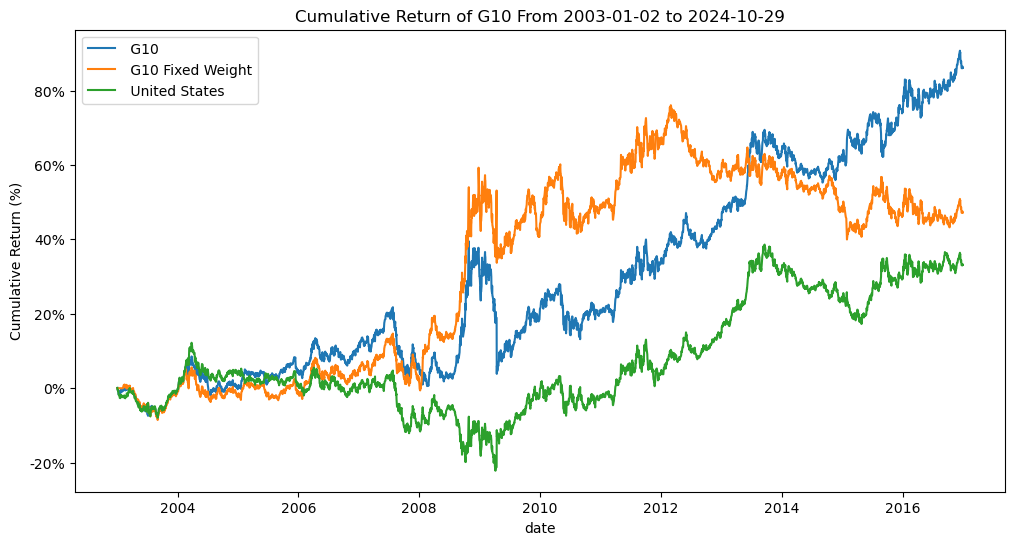

In [9]:
def plot_returns(df_signal: pd.DataFrame) -> plt.Figure: 

    fig, axes = plt.subplots(figsize = (12,6))
    
    (df_signal.rename(
        columns = {"desc": ""}).
        pivot(index = "date", columns = "", values = "signal_rtn").
        fillna(0).
        apply(lambda x: np.cumprod(1 + x) - 1).
        plot(
            ax      = axes,
            ylabel  = "Cumulative Return (%)",
            title   = "Cumulative Return of G10 From {} to {}".format(
                df_citi.date.min(),
                df_citi.date.max())))
    
    axes.yaxis.set_major_formatter(FuncFormatter(lambda x, _: f"{x * 100:.0f}%"))  

plot_returns(df_signal)

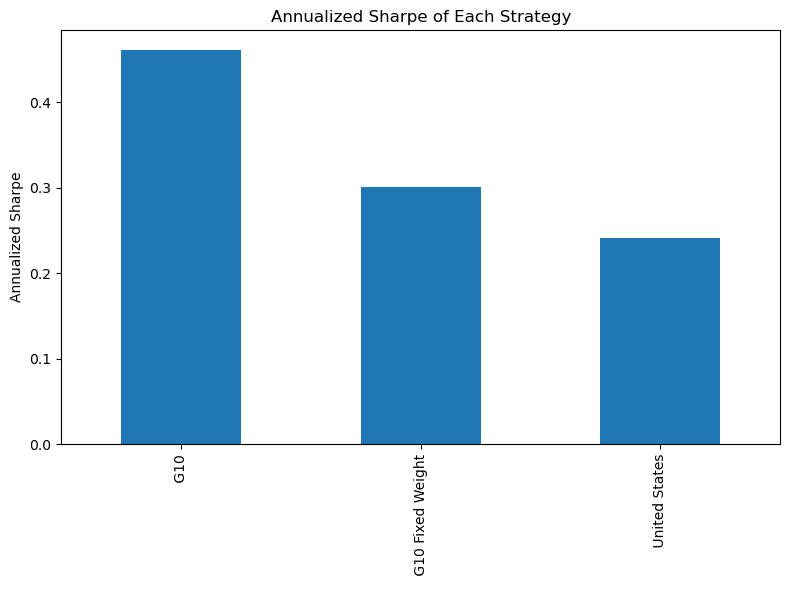

In [10]:
def plot_sharpe(df_signal: pd.DataFrame) -> plt.Figure: 

    (df_signal.drop(
        columns = ["date"]).
        groupby("desc").
        agg(["mean", "std"])
        ["signal_rtn"].
        rename(columns = {
            "mean": "mean_rtn", 
            "std" : "std_rtn"}).
        assign(sharpe = lambda x: x.mean_rtn / x.std_rtn * np.sqrt(252))
        [["sharpe"]].
        plot(
            kind    = "bar",
            legend  = False,
            xlabel  = "",
            ylabel  = "Annualized Sharpe",
            title   = "Annualized Sharpe of Each Strategy",
            figsize = (8,6)))

    plt.tight_layout()

plot_sharpe(df_signal)

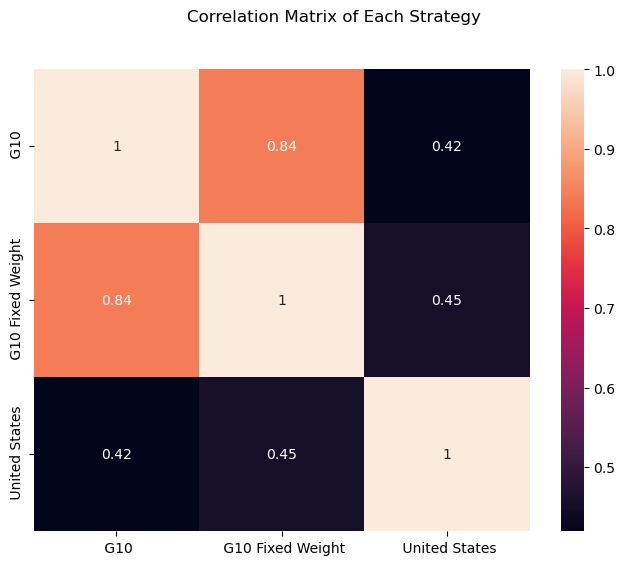

In [11]:
def plot_correlation_matrix(df_signal: pd.DataFrame) -> plt.Figure: 

    df_corr = (df_signal.pivot(
        index = "date", columns = "desc", values = "signal_rtn").
        corr())
    
    fig, axes = plt.subplots(figsize = (8,6))
    sns.heatmap(
        data  = df_corr,
        ax    = axes,
        annot = True)
    
    axes.set_xlabel(""); axes.set_ylabel("")
    fig.suptitle("Correlation Matrix of Each Strategy")

plot_correlation_matrix(df_signal)

## Portfolio Optimization

In [13]:
def get_erc(df_signal: pd.DataFrame, window: int = 30) -> pd.DataFrame: 

    df_vol = (df_signal.pivot(
        index = "date", columns = "desc", values = "signal_rtn").
        ewm(span = window, adjust = False).
        std().
        shift().
        apply(lambda x: 1 / x).
        reset_index().
        melt(id_vars = "date").
        rename(columns = {"value": "inv_vol"}).
        dropna())
    
    df_out = (df_vol.drop(
        columns = ["desc"]).
        groupby("date").
        agg("sum").
        rename(columns = {"inv_vol": "cum_vol"}).
        merge(right = df_vol, how = "inner", on = ["date"]).
        merge(right = df_signal, how = "inner", on = ["date", "desc"]).
        assign(weighted_rtn = lambda x: x.inv_vol / x.cum_vol * x.signal_rtn))

    return df_out

df_erc = get_erc(df_signal)

In [14]:
def get_port(df_signal: pd.DataFrame, df_erc: pd.DataFrame) -> pd.DataFrame: 

    df_mean = (df_signal.drop(
        columns = "desc").
        groupby("date").
        agg("mean").
        rename(columns = {"signal_rtn": "mean_rtn"}))
    
    df_erc_combined = (df_erc[
        ["date", "weighted_rtn"]].
        groupby("date").
        agg("sum").
        rename(columns = {"weighted_rtn": "erc_rtn"}))
    
    df_combined = (df_mean.merge(
        right = df_erc_combined, how = "inner", on = ["date"]))

    return df_combined

df_port = get_port(df_signal, df_erc)

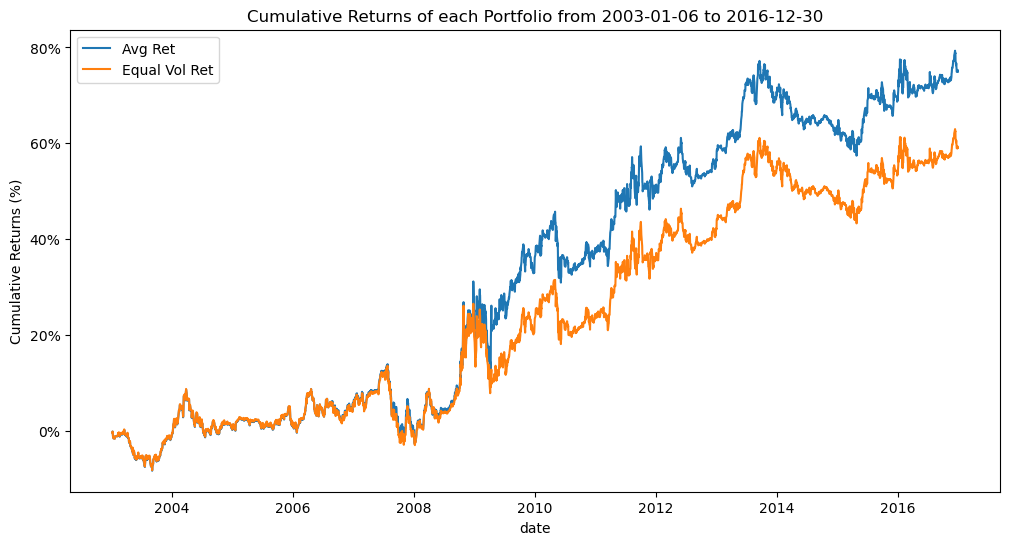

In [15]:
def plot_port(df_port: pd.DataFrame) -> plt.Figure: 

    fig, axes = plt.subplots(figsize = (12,6))
    
    (df_port.rename(
        columns = {
            "mean_rtn": "Avg Ret",
            "erc_rtn" : "Equal Vol Ret"}).
        apply(lambda x: np.cumprod(1 + x) - 1).
        plot(
            ylabel = "Cumulative Returns (%)",
            ax     = axes,
            title  = "Cumulative Returns of each Portfolio from {} to {}".format(
                df_port.index.min(),
                df_port.index.max())))
    
    axes.yaxis.set_major_formatter(FuncFormatter(lambda x, _: f"{x * 100:.0f}%"))

plot_port(df_port)

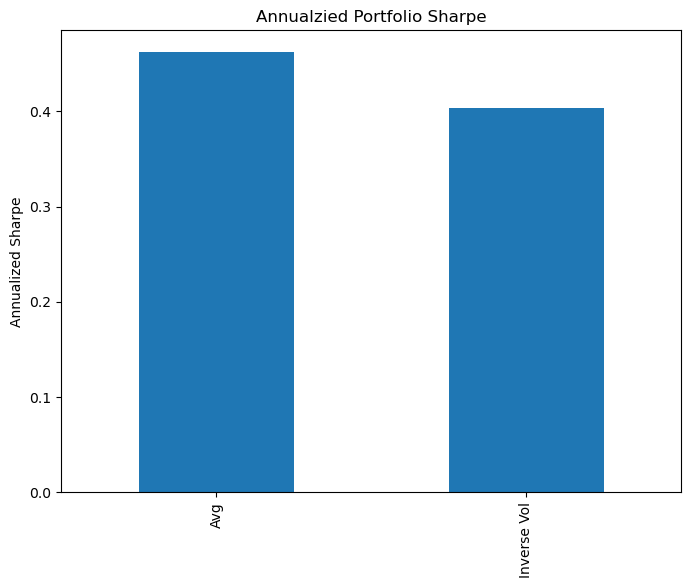

In [16]:
def plot_port_sharpe(df_port: pd.DataFrame) -> plt.Figure: 

    (df_port.reset_index().melt(
        id_vars = "date").
        drop(columns = ["date"]).
        assign(variable = lambda x: x.variable.str.split("_").str[0]).
        assign(variable = lambda x: np.where(x.variable == "erc", "Inverse Vol", "Avg")).
        groupby("variable").
        agg(["mean", "std"])
        ["value"].
        rename(columns = {
            "mean": "mean_rtn", 
            "std" : "std_rtn"}).
        assign(sharpe = lambda x: x.mean_rtn / x.std_rtn * np.sqrt(252))
        [["sharpe"]].
        plot(
            kind = "bar",
            xlabel = "",
            ylabel = "Annualized Sharpe",
            legend = False,
            title  = "Annualzied Portfolio Sharpe",
            figsize = (8,6)))

plot_port_sharpe(df_port)